<a href="https://www.kaggle.com/code/alwanrahmanas/forecast-using-optuna-and-analyzed-by-shap?scriptVersionId=170145997" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv


In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 382 µs (started: 2024-04-03 18:52:20 +00:00)


In [3]:
train = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
test = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')

time: 38.2 ms (started: 2024-04-03 18:52:20 +00:00)


# Exploratory Data Analysis

In [4]:
train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


time: 29.9 ms (started: 2024-04-03 18:52:20 +00:00)


In [5]:
test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


time: 13.3 ms (started: 2024-04-03 18:52:20 +00:00)


In [6]:
train['date'] = pd.to_datetime(train['date'])
train['day'] = train['date'].dt.day
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month

time: 12.1 ms (started: 2024-04-03 18:52:21 +00:00)


In [7]:
test['date'] = pd.to_datetime(test['date'])
test['day'] = test['date'].dt.day
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month

time: 4.81 ms (started: 2024-04-03 18:52:21 +00:00)


In [8]:
train = train.set_index('date')
test = test.set_index('date')

time: 7 ms (started: 2024-04-03 18:52:21 +00:00)


## Summary Statistics

In [9]:
summary_stats_train = train.describe().T
summary_stats_train


,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333
day,1462.0,15.719562,8.808520,1.000000,8.000000,16.000000,23.000000,31.000000
year,1462.0,2014.502736,1.120248,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000
month,1462.0,6.519152,3.451727,1.000000,4.000000,7.000000,10.000000,12.000000


time: 36.9 ms (started: 2024-04-03 18:52:21 +00:00)


In [10]:
summary_stats_test = test.describe().T
summary_stats_test


,count,mean,std,min,25%,50%,75%,max
meantemp,114.0,21.713079,6.360072,11.0000,16.437198,19.875000,27.705357,34.500000
humidity,114.0,56.258362,19.068083,17.7500,39.625000,57.750000,71.902778,95.833333
wind_speed,114.0,8.143924,3.588049,1.3875,5.563542,8.069444,10.068750,19.314286
meanpressure,114.0,1004.035090,89.474692,59.0000,1007.437500,1012.739316,1016.739583,1022.809524
day,114.0,14.894737,8.495046,1.0000,8.000000,15.000000,22.000000,31.000000
year,114.0,2017.000000,0.000000,2017.0000,2017.000000,2017.000000,2017.000000,2017.000000
month,114.0,2.421053,1.104254,1.0000,1.000000,2.000000,3.000000,4.000000


time: 31.3 ms (started: 2024-04-03 18:52:21 +00:00)


## Visualization

This visualization can see the seasonal effect or anomaly from the data

In [11]:
columns_to_exclude = ['day', 'month', 'year']
train_without_time = train.drop(columns=columns_to_exclude)
test_without_time = test.drop(columns=columns_to_exclude)

time: 2.96 ms (started: 2024-04-03 18:52:21 +00:00)


### Train

/tmp/ipykernel_18/2185392421.py:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg = train_without_time.resample('Q').mean()


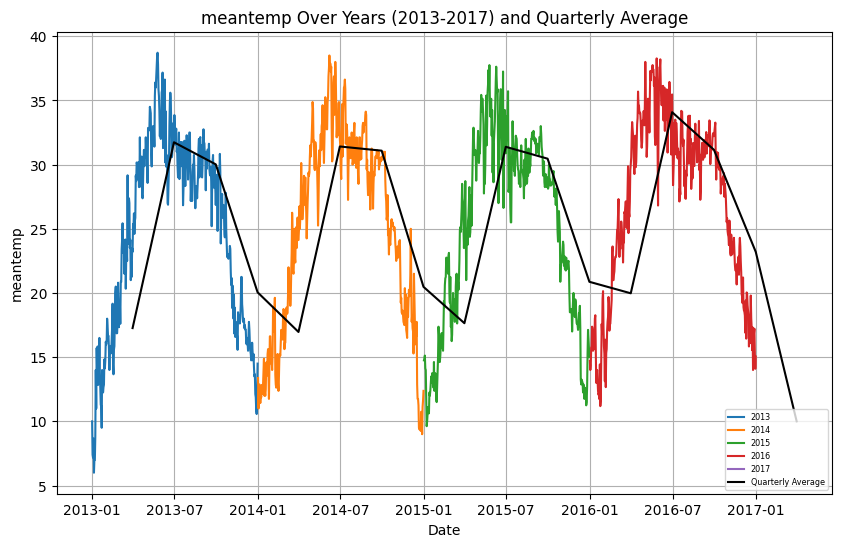


---------------------------------------------



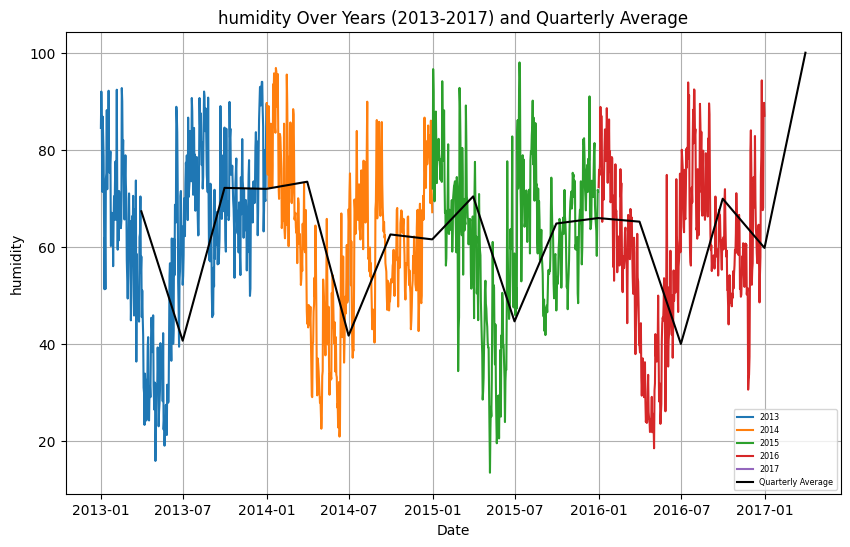


---------------------------------------------



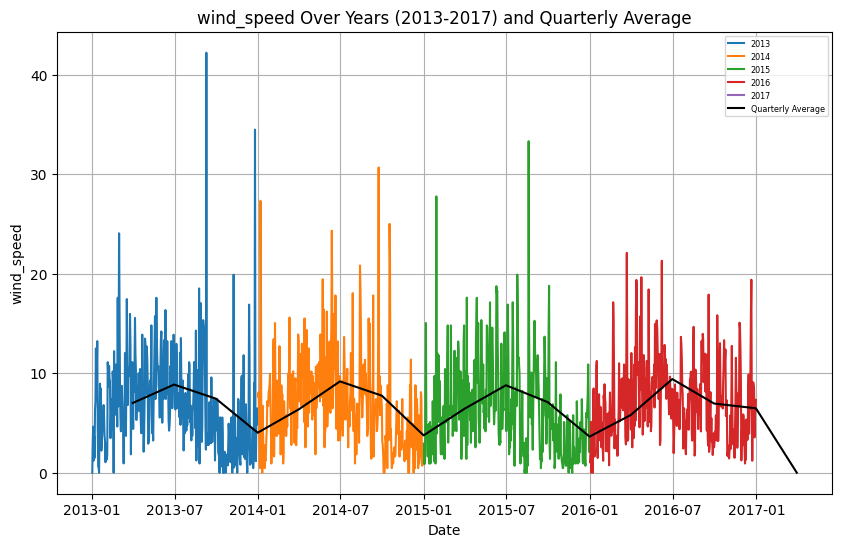


---------------------------------------------



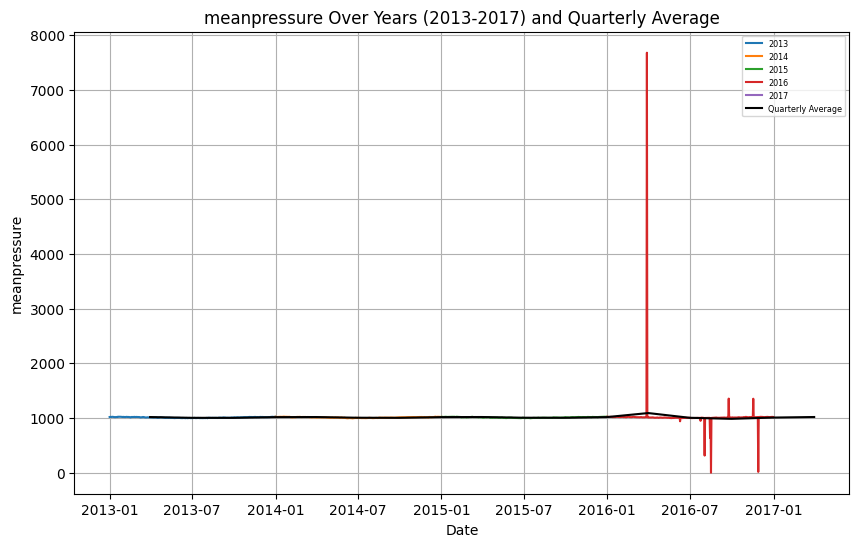


---------------------------------------------

time: 2.24 s (started: 2024-04-03 18:52:21 +00:00)


In [12]:
import matplotlib.pyplot as plt

# Iterate over each variable and plot its trend for each year and quarterly average
for column in train_without_time.columns:
    plt.figure(figsize=(10, 6))

    # Plot yearly trends
    for year in range(2013, 2018):
        data_year = train_without_time[train_without_time.index.year == year]
        plt.plot(data_year.index, data_year[column], label=str(year))

    # Calculate quarterly average
    quarterly_avg = train_without_time.resample('Q').mean()

    # Plot quarterly average
    plt.plot(quarterly_avg.index, quarterly_avg[column], label='Quarterly Average', linestyle='-', color='black')

    plt.title(f'{column} Over Years (2013-2017) and Quarterly Average')
    plt.xlabel('Date')
    plt.ylabel(column)

    if column in ['meantemp', 'humidity']:
        legend_loc = 'lower right'
    else:
        legend_loc = 'upper right'

    plt.legend(loc=legend_loc, fontsize='xx-small')  # Adjust legend position and size
    plt.grid(True)
    plt.show()
    print('\n---------------------------------------------\n')


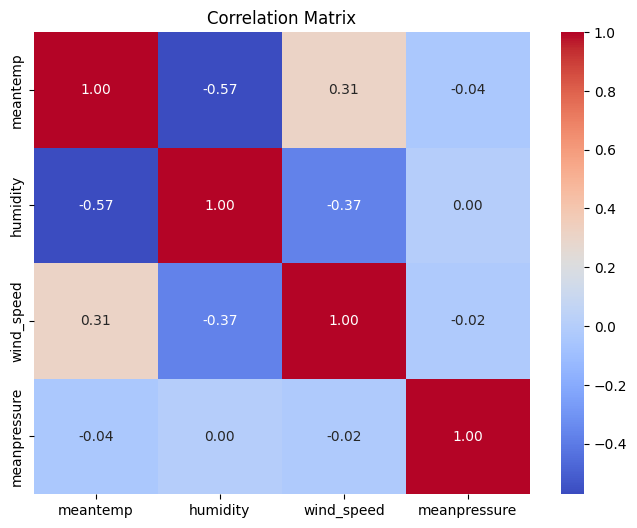

time: 2.01 s (started: 2024-04-03 18:52:23 +00:00)


In [13]:
import seaborn as sns

corr = train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


nothing much to say for this correlation

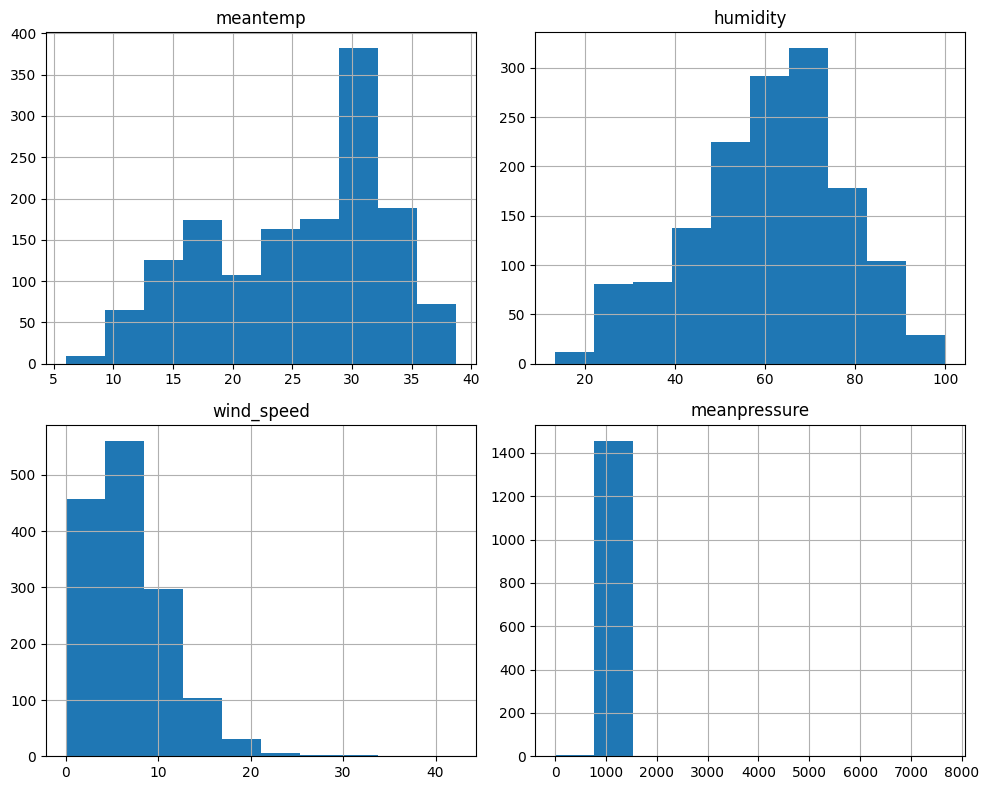

time: 1.28 s (started: 2024-04-03 18:52:25 +00:00)


In [14]:
# Plot histogram
train_without_time.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()


### Test

In [15]:
test

,meantemp,humidity,wind_speed,meanpressure,day,year,month
date,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,1,2017,1
2017-01-02,18.500000,77.222222,2.894444,1018.277778,2,2017,1
2017-01-03,17.111111,81.888889,4.016667,1018.333333,3,2017,1
2017-01-04,18.700000,70.050000,4.545000,1015.700000,4,2017,1
2017-01-05,18.388889,74.944444,3.300000,1014.333333,5,2017,1
...,...,...,...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000,20,2017,4
2017-04-21,34.250000,39.375000,6.962500,999.875000,21,2017,4
2017-04-22,32.900000,40.900000,8.890000,1001.600000,22,2017,4


time: 15.5 ms (started: 2024-04-03 18:52:27 +00:00)


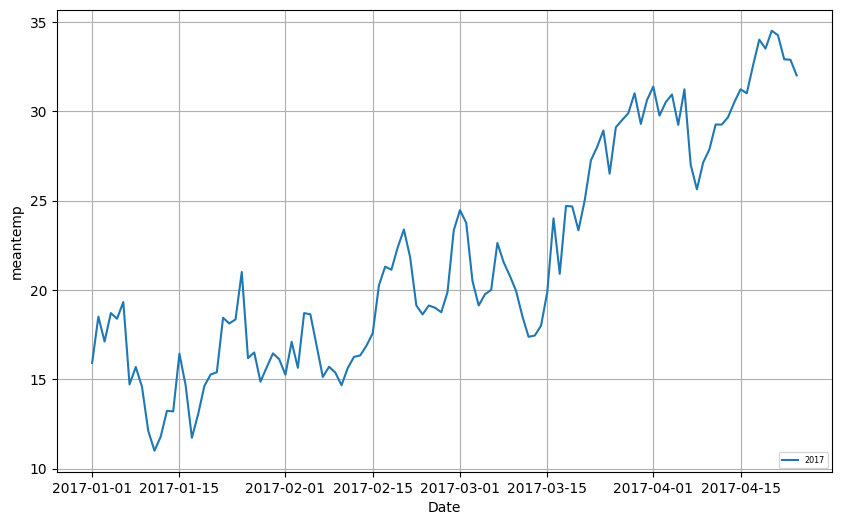


---------------------------------------------



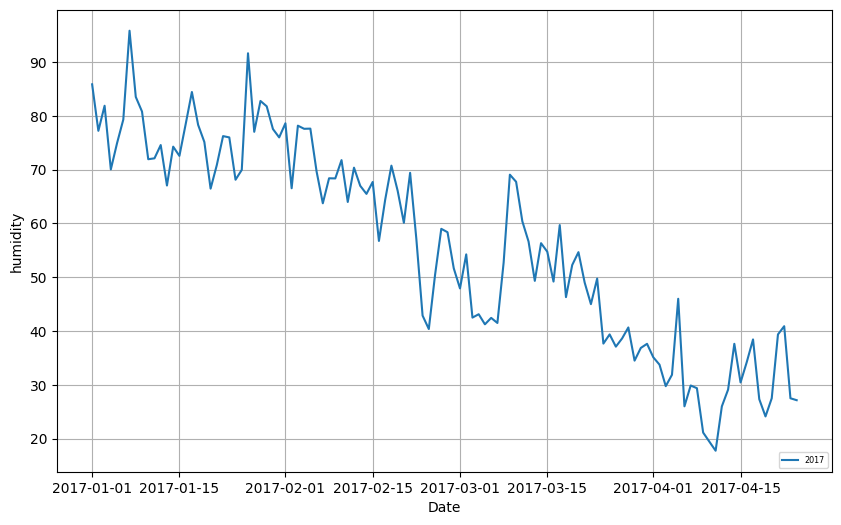


---------------------------------------------



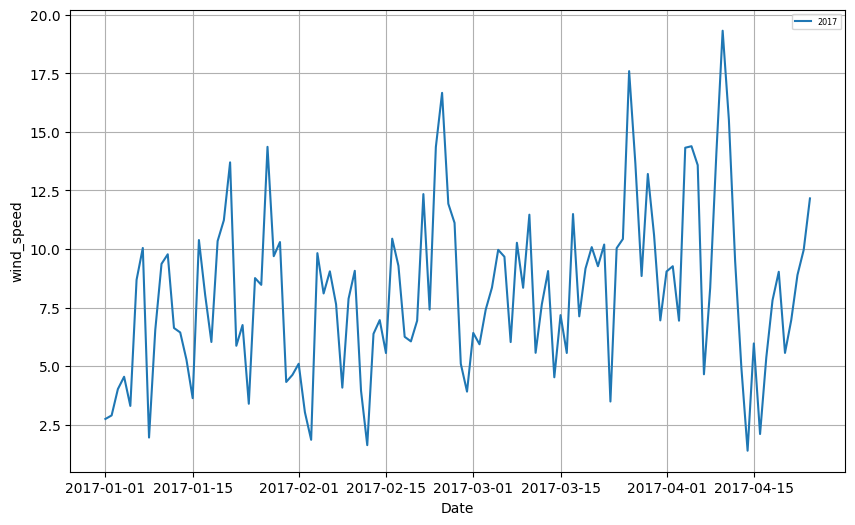


---------------------------------------------



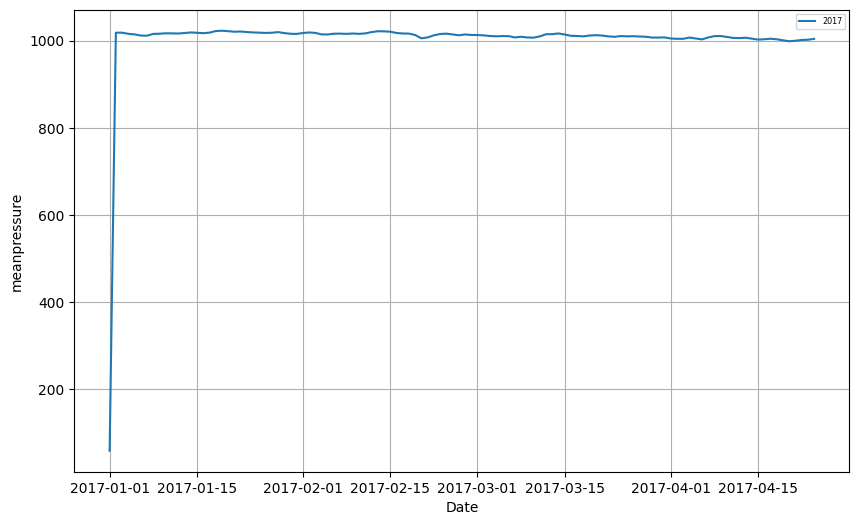


---------------------------------------------

time: 1.66 s (started: 2024-04-03 18:52:27 +00:00)


In [16]:
import matplotlib.pyplot as plt

# Iterate over each variable and plot its trend for each year and quarterly average
for column in test_without_time.columns:
    plt.figure(figsize=(10, 6))
    
    # Plot yearly trends
    for year in range(2017,2018):
        data_year = test_without_time[test_without_time.index.year == year]
        plt.plot(data_year.index, data_year[column], label=str(year))
        
    plt.xlabel('Date')
    plt.ylabel(column)
    
    if column in ['meantemp', 'humidity']:
        legend_loc = 'lower right'
    else:
        legend_loc = 'upper right'
    
    plt.legend(loc=legend_loc, fontsize='xx-small')  # Adjust legend position and size
    plt.grid(True)
    plt.show()
    print('\n---------------------------------------------\n')


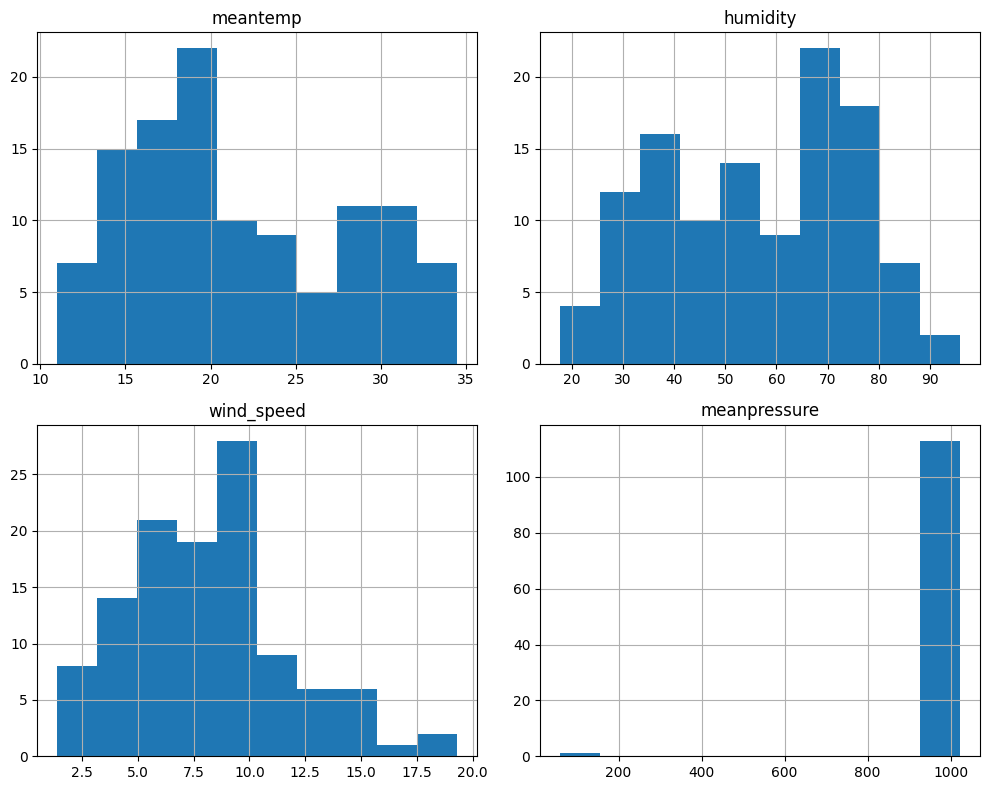

time: 1.17 s (started: 2024-04-03 18:52:29 +00:00)


In [17]:
# Plot histogram
test_without_time.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()


You can say there is an outlier in meanpressure, we can check it out after this

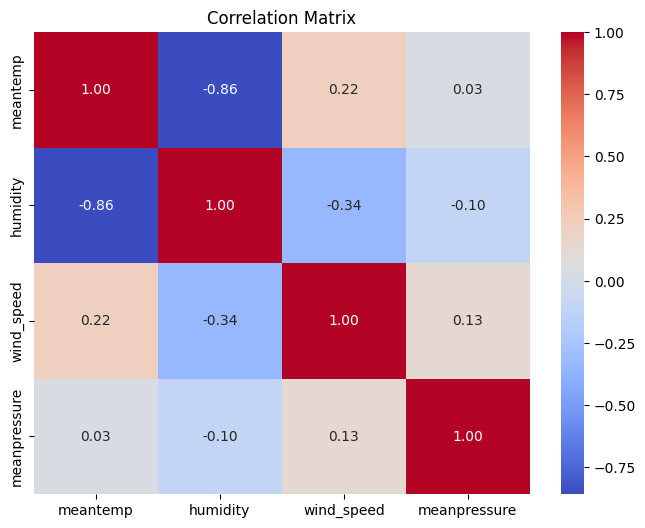

time: 516 ms (started: 2024-04-03 18:52:30 +00:00)


In [18]:
import seaborn as sns

corr = test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


For the test data, humidity has strong negative correlation

# Preprocessing

Based on graphic, aparently the first row of test is an anomali. Considering the nearest value and data pattern, I replace the first row of test with the last row of train because they are having a same date

In [19]:
train.tail(2)

,meantemp,humidity,wind_speed,meanpressure,day,year,month
date,,,,,,,
2016-12-31,15.052632,87.0,7.325,1016.1,31,2016,12
2017-01-01,10.000000,100.0,0.000,1016.0,1,2017,1


time: 12.9 ms (started: 2024-04-03 18:52:31 +00:00)


In [20]:
test.head(2)

,meantemp,humidity,wind_speed,meanpressure,day,year,month
date,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,1,2017,1
2017-01-02,18.500000,77.222222,2.894444,1018.277778,2,2017,1


time: 11.5 ms (started: 2024-04-03 18:52:31 +00:00)


In [21]:
# Get the last row of train
last_row_train = train.iloc[-1]

# Replace the first row of test with the last row of train
test.iloc[0] = last_row_train


time: 3.69 ms (started: 2024-04-03 18:52:31 +00:00)


In [22]:
# Now see the first row again
test.head(2)

,meantemp,humidity,wind_speed,meanpressure,day,year,month
date,,,,,,,
2017-01-01,10.0,100.000000,0.000000,1016.000000,1,2017,1
2017-01-02,18.5,77.222222,2.894444,1018.277778,2,2017,1


time: 9.29 ms (started: 2024-04-03 18:52:31 +00:00)


## Checking the Missing Value

In [23]:
# Check for missing values in train
train_missing = train.isnull().sum()
print("Missing values in train:\n", train_missing)

# Check for missing values in test
test_missing = test.isnull().sum()
print("\nMissing values in test:\n", test_missing)


Missing values in train:
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
day             0
year            0
month           0
dtype: int64

Missing values in test:
 meantemp        0
humidity        0
wind_speed      0
meanpressure    0
day             0
year            0
month           0
dtype: int64
time: 3.63 ms (started: 2024-04-03 18:52:31 +00:00)


There are no missing value and data are well-prepared so we can go on modeling

# Modeling

I'm gonna use Optuna x XGBoost for this data

In [24]:
# To perform fit and predict, we need to split our training data
from sklearn.model_selection import train_test_split

X = train.drop('meantemp', axis=1)
y = train['meantemp']  

X_df_test = test.drop('meantemp',axis=1)
y_df_test = test['meantemp']

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

time: 344 ms (started: 2024-04-03 18:52:32 +00:00)


In [25]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error


# Define objective function
def objective(trial):
    # Define search space for hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }


    # Train XGBoost model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    model = xgb.train(params, dtrain, evals=[(dval, 'eval')], early_stopping_rounds=10, verbose_eval=False)

    # Get validation predictions
    y_pred = model.predict(dval)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    return rmse

# Create Optuna study
study = optuna.create_study(direction='minimize')

# Run optimization
study.optimize(objective, n_trials=100)

# Print best hyperparameters and result
print('Best trial:')
trial = study.best_trial
print('  Value: {:.4f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


[I 2024-04-03 18:52:32,920] A new study created in memory with name: no-name-1edef2c6-529d-450a-a7af-0d0eb719fca9
/tmp/ipykernel_18/2604491264.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
/tmp/ipykernel_18/2604491264.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
/tmp/ipykernel_18/2604491264.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 

Best trial:
  Value: 1.7765
  Params: 
    booster: gbtree
    lambda: 0.0017453731501892616
    alpha: 2.2359583019266003e-07
    max_depth: 6
    eta: 0.31530771144925845
    gamma: 0.00016051763586504285
    grow_policy: lossguide
time: 10.1 s (started: 2024-04-03 18:52:32 +00:00)


In [26]:
# Get the best params
best_params=trial.params

time: 513 µs (started: 2024-04-03 18:52:42 +00:00)


In [27]:
# Initialize XGBoost regressor with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)

# Train the model on your training data
best_model.fit(X_train, y_train)

XGBRegressor(alpha=2.2359583019266003e-07, base_score=None, booster='gbtree',
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.31530771144925845,
             eval_metric=None, feature_types=None, gamma=0.00016051763586504285,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, lambda=0.0017453731501892616,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None, ...)

time: 278 ms (started: 2024-04-03 18:52:42 +00:00)


In [28]:
# Get the prediction
pred = best_model.predict(X_df_test)

time: 6.33 ms (started: 2024-04-03 18:52:43 +00:00)


## Evaluate the performance of model

In [29]:
from sklearn.metrics import mean_squared_error

# Defining MAPE 
def calculate_mape(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Calculate absolute percentage error for each data point
    ape = np.abs((actual - predicted) / actual)
    
    # Replace infinite values with NaN and remove them
    ape = np.where(np.isfinite(ape), ape, np.nan)
    ape = ape[~np.isnan(ape)]
    
    # Calculate MAPE
    mape = np.mean(ape) * 100
    
    return mape

# Defining RMSE
def calculate_rmse(actual, predicted):
    # Calculate RMSE
    rmse = mean_squared_error(actual, predicted, squared=False)
    return rmse

# Defining MAE
def calculate_mae(actual, predicted):
    # Calculate MAE
    mae = mean_absolute_error(actual, predicted)
    return mae

time: 1.51 ms (started: 2024-04-03 18:52:43 +00:00)


In [30]:
print(f"MAPE: {calculate_mape(y_df_test,pred)}")
print(f"RMSE: {calculate_rmse(y_df_test,pred)}")


MAPE: 12.78614314047695
RMSE: 3.1695440651411957
time: 2.66 ms (started: 2024-04-03 18:52:43 +00:00)


# Feature Importance from The Model

<Figure size 1000x600 with 0 Axes>

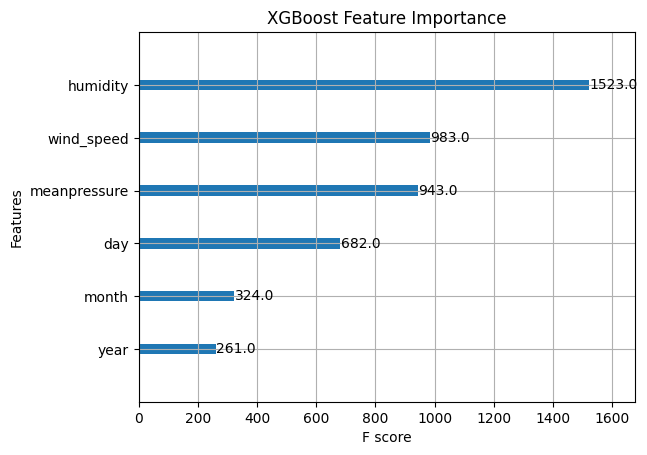

time: 323 ms (started: 2024-04-03 18:52:44 +00:00)


In [31]:
# We can use this to evaluate how variable affecting the performance of the model
# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model, max_num_features=10)  # Adjust max_num_features as needed
plt.title('XGBoost Feature Importance')
plt.show()

as you can see, variable humidity contribute the most for the performance of XGBoost

In [32]:
import shap

# Run initjs() to load the required JavaScript library
shap.initjs()


time: 6.58 s (started: 2024-04-03 18:52:44 +00:00)


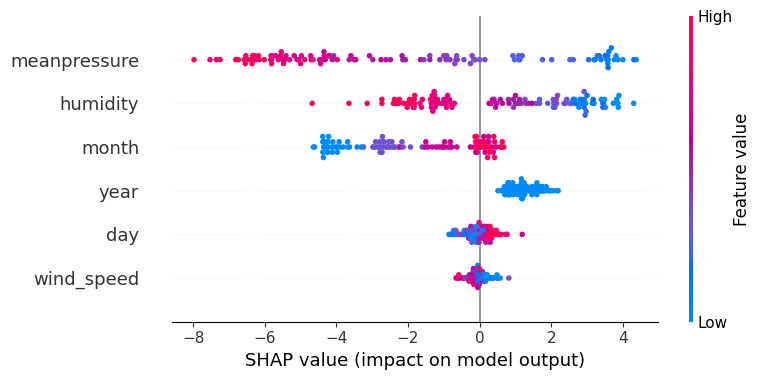

time: 7.75 s (started: 2024-04-03 18:52:51 +00:00)


In [33]:
import shap

# Wrap the XGBoost model in a function
def model_predict(data):
    return best_model.predict(data)

# Initialize the SHAP explainer with the callable model function
explainer = shap.Explainer(model_predict, X_train)

# Calculate SHAP values
shap_values = explainer(X_df_test)

# Summary plot
shap.summary_plot(shap_values, X_df_test, feature_names=X_df_test.columns)

# Force plot for a single prediction (replace index with the desired data point)
shap.force_plot(shap_values.base_values[0], shap_values.values[0], X_df_test.iloc[0])

A positive SHAP value for a feature indicates that the feature pushes the prediction higher, while a negative SHAP value indicates that the feature pushes the prediction lower.

* Y-axis indicates the feature names in order of importance from top to bottom.
* X-axis represents the SHAP value, which indicates the degree of change in log odds.
* The color of each point on the graph represents the value of the corresponding feature, with red indicating high values and blue indicating low values.
* Each point represents a row of data from the original dataset.

From [DataCamp](https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability)